## 初始化与计算

In [2]:
import os,sys
sys.path.append('/media/zkd/Windows/Users/ION/Desktop/241209_393锁定')
from Photon_infere import *

### 计算光子数

In [ ]:
# 光计数窗口
window_start=80*1e3 # unit ps
window_end=112*1e3    # unit ps
# 分析数据截至时间
period=500e-6 # unit seconds
time_start=000 # unit seconds
time_stop=140000  # unit seconds
#脉冲
pulse_num=9
pulse_interval=5e6 # unit ps  

c3_path=''
c4_path=''

In [ ]:
pmt_array=np.fromfile(c3_path,dtype=np.uint64).reshape(-1,2)
pmt1_df=pd.DataFrame(pmt_array,columns=['time_satmp','start_index'])
pmt_array=np.fromfile(c4_path,dtype=np.uint64).reshape(-1,2)
pmt2_df=pd.DataFrame(pmt_array,columns=['time_satmp','start_index'])
## 时间限制
pmt1_df=pmt1_df[(pmt1_df['start_index']>=time_start/period)&(pmt1_df['start_index']<=time_stop/period)].copy()
pmt2_df=pmt2_df[(pmt2_df['start_index']>=time_start/period)&(pmt2_df['start_index']<=time_stop/period)].copy()
## 计算时间窗内光子数
pmt1_index=window_index(pmt1_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt2_index=window_index(pmt2_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt1_count=pmt1_df[pmt1_index]['start_index'].value_counts().sort_index(ascending=True)
pmt2_count=pmt2_df[pmt2_index]['start_index'].value_counts().sort_index(ascending=True)
PMT1_SUM=pmt1_count.sum()
PMT2_SUM=pmt2_count.sum()
print('pmt1:{}, pmt2:{}'.format(PMT1_SUM,PMT2_SUM))
max_time=max(pmt1_count.index.max(),pmt2_count.index.max())*period
print('cps1:{}, cps2:{}'.format(PMT1_SUM/max_time,PMT2_SUM/max_time))

pmt1:172, pmt2:149


## 时域分布

 TDC histgram with pulse num:9, pulse interval:5.0us.


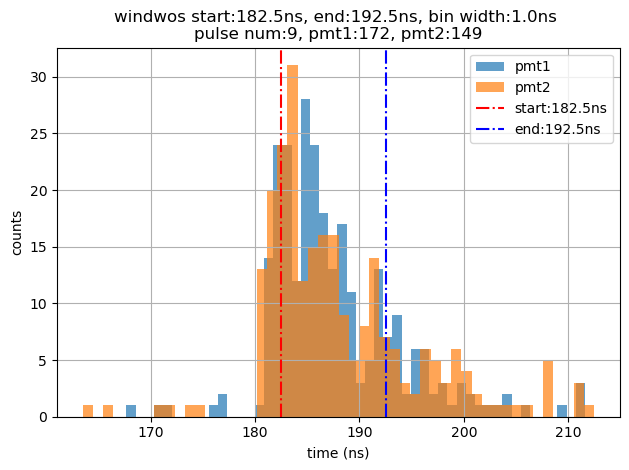

cumsum with pulse num:9.


/tmp/ipykernel_62311/1416087460.py:48: RuntimeWarning:

invalid value encountered in divide



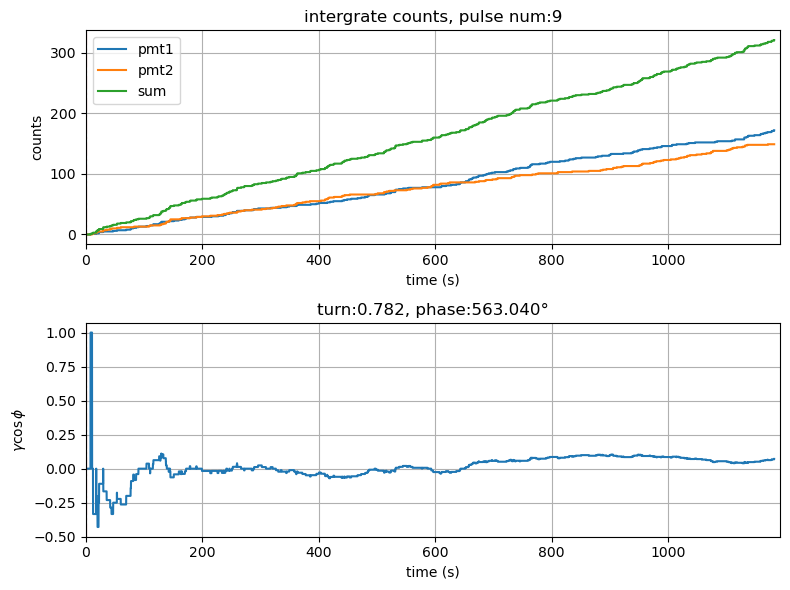

In [ ]:
### 光子时间分布 
def hist_count(pmt1_df,pmt2_df,bin_t):
    """
    计数窗口内的光子数量，并绘制直方图展示不同探测器的光子计数随时间的分布。

    参数:
    pmt1_df (pandas.DataFrame): 第一个探测器的数据框，包含 'time_satmp' 列。
    pmt2_df (pandas.DataFrame): 第二个探测器的数据框，包含 'time_satmp' 列。
    bin_t (int): 直方图的时间间隔，单位为皮秒 (ps)。

    返回:
    无
    """
    hist_time_wid=20e3 # unit ps
    # bin_t=1000 #ps
    pmt1_hist_index=window_index(pmt1_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt2_hist_index=window_index(pmt2_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt1_hist_ts=pmt1_df['time_satmp'][pmt1_hist_index]%pulse_interval
    pmt2_hist_ts=pmt2_df['time_satmp'][pmt2_hist_index]%pulse_interval
    info='windwos start:{:,.1f}ns, end:{:,.1f}ns, bin width:{:.1f}ns \n'.format(window_start/1e3,window_end/1e3, bin_t/1e3)
    info+='pulse num:{}, pmt1:{:,.0f}, pmt2:{:,.0f}'.format(pulse_num,PMT1_SUM,PMT2_SUM)
    bin_wid=int((window_end-window_start+2*hist_time_wid)//bin_t) # width of bin is 100ps 
    plt.hist(pmt1_hist_ts/1000,bins=bin_wid,label='pmt1',alpha=0.7)
    plt.hist(pmt2_hist_ts/1000,bins=bin_wid,label='pmt2',alpha=0.7)
    plt.xlabel('time (ns)')
    plt.ylabel('counts')
    plt.axvline(window_start/1000,color='r',linestyle='-.',label='start:{:.1f}ns'.format(window_start/1000))
    plt.axvline(window_end/1000,color='b',linestyle='-.',label='end:{:.1f}ns'.format(window_end/1000))
    plt.legend(loc=1)
    plt.title(info)
    plt.tight_layout()
    plt.grid()
print(' TDC histgram with pulse num:{}, pulse interval:{:.1f}us.'.format(pulse_num,pulse_interval/1e6))
hist_count(pmt1_df,pmt2_df,bin_t=1000)
plt.show()
### PMT 计数时间累积
def plot_cumsum(pmt1_count,pmt2_count,period=500e-6):
    "画出累加计数和相位估计"
    max_time=max(pmt1_count.index.max(),pmt2_count.index.max())
    time_index=np.arange(0,max_time+1,1)
    pmt1=np.zeros_like(time_index)
    pmt2=np.zeros_like(time_index)
    pmt1[pmt1_count.index]=pmt1_count.values
    pmt2[pmt2_count.index]=pmt2_count.values
    pmt1=pmt1.cumsum()
    pmt2=pmt2.cumsum()
    time_len=time_index[-1]*period
    cps1=pmt1[-1]/time_len
    cps2=pmt2[-1]/time_len
    print('cps1:{:.4f}, cps2:{:.4f}'.format(cps1,cps2))
    fig=plt.figure(figsize=(8,6))
    plt.plot(time_index*period,pmt1,label='pmt1 cps:{:.4f}'.format(cps1))
    plt.plot(time_index*period,pmt2,label='pmt2 cps:{:.4f}'.format(cps2))
    plt.plot(time_index*period,pmt1+pmt2,label='sum')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.legend(loc=2)
    plt.title('intergrate counts, pulse num:{:.0f}'.format(pulse_num))
    plt.xlabel('time (s)')
    plt.ylabel('counts')
    plt.grid()
    return fig
print('cumsum with pulse num:{:.0f}.'.format(pulse_num))
plot_cumsum(pmt1_count,pmt2_count,period=period)
plt.show()